In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import arviz as az
import warnings
warnings.warn('ignore')

/home/anders/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/tmp/ipykernel_5328/690037048.py:12: UserWarning: ignore
  warnings.warn('ignore')


In [171]:
def target_func(x):
  return torch.sin(20*x) + 2*torch.cos(14*x) - 2*torch.sin(6*x)

X = torch.tensor([-1, -1/2, 0, 1/2, 1])

y = target_func(X)

In [198]:
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
kernel.variance = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
kernel.lengthscale = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
gpmodel = gp.models.GPRegression(X, y, kernel=kernel, noise = torch.tensor(1e-4))

hmc_kernel = pyro.infer.NUTS(gpmodel.model)

mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=500, warmup_steps = 5)
    
mcmc.run()


Sample: 100%|██████████| 505/505 [00:55,  9.04it/s, step size=7.34e-02, acc. prob=0.997]


/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:166: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


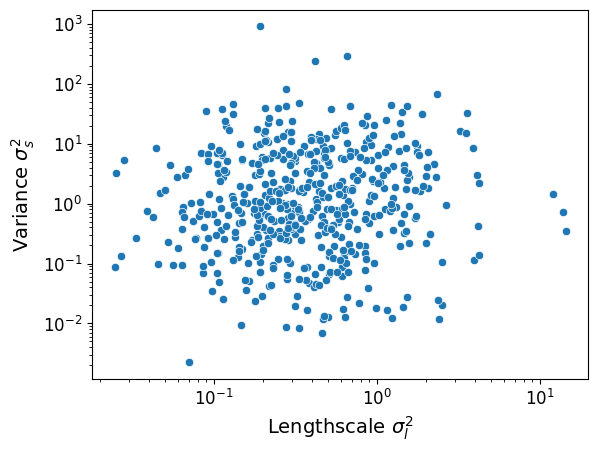

In [39]:
lengthprior = torch.distributions.LogNormal(-1, 1)
varianceprior = torch.distributions.LogNormal(0, 2)
x1 = lengthprior.sample_n(500)
y1 = varianceprior.sample_n(500)

f, ax = plt.subplots()
ax.set(xscale="log", yscale="log")
sns.scatterplot(x = x1, y = y1)
ax.set_xlabel("Lengthscale $\sigma_l^2$", fontsize = 14)
ax.set_ylabel("Variance $\sigma_s^2$", fontsize = 14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()



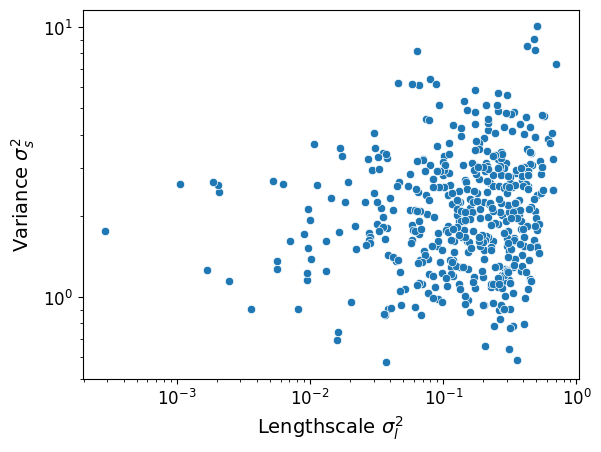

In [38]:
hyperparam = mcmc.get_samples()
x1 = hyperparam["kernel.lengthscale"][0:499]
y1 = hyperparam["kernel.variance"][0:499]

f, ax = plt.subplots()
ax.set(xscale="log", yscale="log")
sns.scatterplot(x = x1, y = y1)
ax.set_xlabel("Lengthscale $\sigma_l^2$", fontsize = 14)
ax.set_ylabel("Variance $\sigma_s^2$", fontsize = 14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

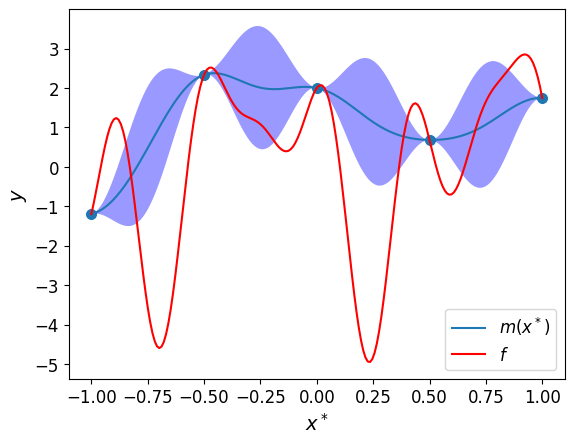

In [154]:
with torch.no_grad():
    x_new = torch.linspace(-1, 1, 200)
    mean_new = gpmodel.forward(x_new)[0] # Returns the mean of our posterior samples
    sd_new = gpmodel.forward(x_new)[1] # Returns the standard deviation of our posteriour samples
    f, ax = plt.subplots(1)
    sns.lineplot(x = x_new, y = mean_new, ax=ax, label = "$m(x^*)$")
    sns.scatterplot(x = X, y = y, ax=ax, s = 75)
    ax.fill_between(x_new, mean_new+2*sd_new, mean_new-2*sd_new, facecolor='blue', alpha=0.4)
    sns.lineplot(x = x_new, y = target_func(x_new), ax = ax, label =  "$f$", color = "red")
    ax.legend(loc='lower right', fontsize = 12)
    ax.set_xlabel("$x^*$", fontsize = 14)
    ax.set_ylabel("$y$", fontsize = 14)
    plt.yticks([-5, -4, -3, -2, -1, 0, 1, 2, 3],fontsize=12)
    plt.xticks(fontsize=12)
    plt.show()
    

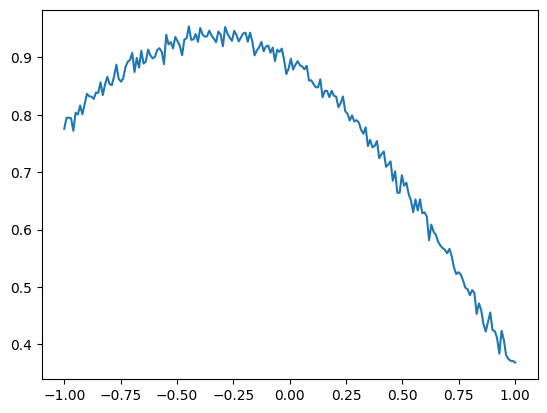

In [36]:
# plot prior
covprior = kernel.forward(x_new) + torch.tensor(1e-4).expand(x_new.shape[0]).diag()

yprior = dist.MultivariateNormal(
            torch.zeros(x_new.shape[0]), covariance_matrix=covprior
        ).sample(sample_shape=(1,))

sns.lineplot(x = x_new, y = yprior[0])
plt.show()


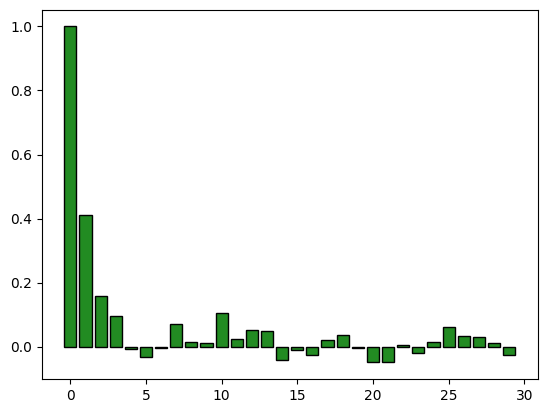

In [199]:
# Autocorrelation plot

diag = az.from_pyro(mcmc, log_likelihood = False)
samples0 = mcmc.get_samples()
#az.plot_autocorr(diag)
#autocorr1 = az.autocorr(samples0["kernel.lengthscale"])
autocorr2 = az.autocorr(samples0["kernel.variance"])
xs = torch.arange(0, autocorr2.shape[0], 1)
plt.bar(x = xs[xs<30], height = autocorr2[xs<30], align='center', color=['forestgreen'], edgecolor='black')
#sns.barplot(x = xs, y = autocorr2)
#plt.axhline(y = 0, color = "black", linestyle='dashed')
plt.show()

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


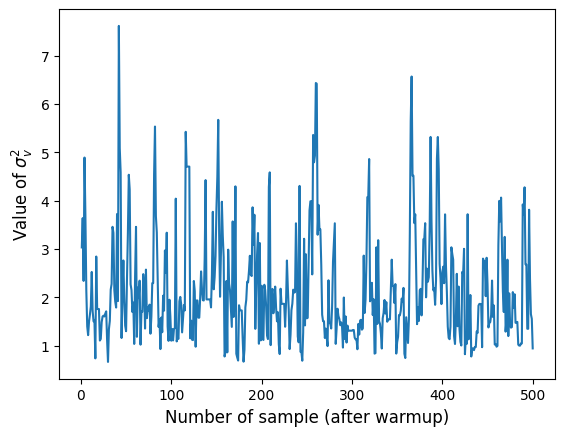

In [210]:
sum1 = az.summary(diag)
params =  az.extract(diag)

samples_kernel_lengthscale = params["kernel.lengthscale"]
samples_kernel_variance = params["kernel.variance"]

xs = np.arange(1, samples_kernel_variance.shape[0]+1, 1)

f, ax = plt.subplots()

#sns.lineplot(x = xs, y = samples_kernel_lengthscale, ax = ax)
sns.lineplot(x = xs, y = samples_kernel_variance, ax = ax)
ax.set_xlabel("Number of sample (after warmup)", fontsize = 12)
ax.set_ylabel("Value of $\sigma_v^2$", fontsize = 12)
plt.show()



In [201]:
sum1

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kernel.lengthscale,0.217,0.149,0.003,0.471,0.018,0.013,59.0,92.0,NaN
kernel.variance,2.115,1.108,0.582,3.844,0.075,0.053,209.0,211.0,NaN


In [216]:
warmup_array = np.array([50, 100, 200, 300, 600, 800, 1000])
diag_array = np.empty([warmup_array.size, 6])
mean_calc_arrary = np.empty([4,4])


for i in range(warmup_array.size):
    print(str(i) + ": Start")
    for j in range(4):
        pyro.clear_param_store()
        kernel = gp.kernels.RBF(input_dim=1)
        kernel.variance = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
        kernel.lengthscale = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
        gpmodel = gp.models.GPRegression(X, y, kernel=kernel, noise = torch.tensor(1e-4))

        hmc_kernel = pyro.infer.NUTS(gpmodel.model)

        mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=1000, warmup_steps = warmup_array[i])
        mcmc.run()
        print(str(i) + ": past MCMC")
        
        diag = az.from_pyro(mcmc)
        params =  az.extract(diag)
        print(str(i) + ": past arviz")
        sum2 = az.summary(diag)
        mean_calc_arrary[j][0] = sum2["ess_bulk"][0]
        mean_calc_arrary[j][1] = sum2["ess_bulk"][1]
        mean_calc_arrary[j][2] = sum2["ess_tail"][0]
        mean_calc_arrary[j][3] = sum2["ess_tail"][1]

    temp_array = np.mean(mean_calc_arrary, axis = 0)
    
    diag_array[i][0] = temp_array[0]
    diag_array[i][1] = temp_array[1]
    diag_array[i][2] = temp_array[2]
    diag_array[i][3] = temp_array[3]


Sample: 100%|██████████| 1300/1300 [00:48, 26.75it/s, step size=3.82e-01, acc. prob=0.829]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


3: past MCMC
3: past arviz


Sample: 100%|██████████| 1300/1300 [00:59, 21.89it/s, step size=2.58e-01, acc. prob=0.844]


3: past MCMC
3: past arviz


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Sample: 100%|██████████| 1300/1300 [00:42, 30.82it/s, step size=3.98e-01, acc. prob=0.772]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


3: past MCMC
3: past arviz


Sample: 100%|██████████| 1300/1300 [00:43, 29.85it/s, step size=3.44e-01, acc. prob=0.817]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


3: past MCMC
3: past arviz
4: Start


Sample: 100%|██████████| 1600/1600 [00:59, 26.70it/s, step size=2.57e-01, acc. prob=0.893]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


4: past MCMC
4: past arviz


Sample: 100%|██████████| 1600/1600 [00:39, 40.77it/s, step size=4.48e-01, acc. prob=0.787]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


4: past MCMC
4: past arviz


Sample: 100%|██████████| 1600/1600 [00:48, 33.32it/s, step size=3.17e-01, acc. prob=0.868]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


4: past MCMC
4: past arviz


Sample: 100%|██████████| 1600/1600 [01:09, 22.98it/s, step size=2.49e-01, acc. prob=0.933]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


4: past MCMC
4: past arviz
5: Start


Sample: 100%|██████████| 1800/1800 [01:17, 23.19it/s, step size=2.61e-01, acc. prob=0.889]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


5: past MCMC
5: past arviz


Sample: 100%|██████████| 1800/1800 [01:06, 27.27it/s, step size=3.11e-01, acc. prob=0.826]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


5: past MCMC
5: past arviz


Sample: 100%|██████████| 1800/1800 [01:09, 25.84it/s, step size=3.34e-01, acc. prob=0.847]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


5: past MCMC
5: past arviz


Sample: 100%|██████████| 1800/1800 [01:00, 29.56it/s, step size=3.43e-01, acc. prob=0.838]


5: past MCMC


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


5: past arviz
6: Start


Sample: 100%|██████████| 2000/2000 [01:13, 27.28it/s, step size=4.98e-01, acc. prob=0.778]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


6: past MCMC
6: past arviz


Sample: 100%|██████████| 2000/2000 [02:14, 14.86it/s, step size=1.44e-01, acc. prob=0.965]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


6: past MCMC
6: past arviz


Sample: 100%|██████████| 2000/2000 [01:31, 21.91it/s, step size=2.38e-01, acc. prob=0.888]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


6: past MCMC
6: past arviz


Sample: 100%|██████████| 2000/2000 [01:18, 25.59it/s, step size=3.33e-01, acc. prob=0.821]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


6: past MCMC
6: past arviz


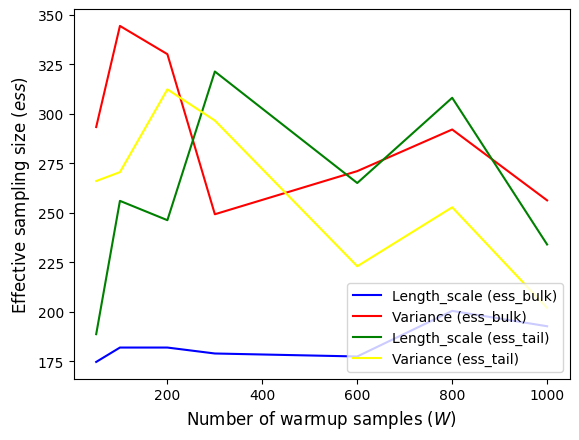

In [217]:
f, ax = plt.subplots(1, 1)

ax.plot(warmup_array, diag_array[:, 0], color="blue", label="Length_scale (ess_bulk)", linestyle="-")
ax.plot(warmup_array, diag_array[:, 1], color="red", label="Variance (ess_bulk)", linestyle="-")
ax.plot(warmup_array, diag_array[:, 2], color="green", label="Length_scale (ess_tail)", linestyle="-")
ax.plot(warmup_array, diag_array[:, 3], color="yellow", label="Variance (ess_tail)", linestyle="-")
ax.set_ylabel("Effective sampling size $(ess)$", fontsize = 12)
ax.set_xlabel("Number of warmup samples $(W)$", fontsize = 12)
ax.legend(loc='lower right')

plt.show()


# PART 2

In [26]:
import torch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import arviz as az
import warnings
warnings.filterwarnings('ignore')

In [85]:
def target_func(x):
  return torch.sin(20*x) + 2*torch.cos(14*x) - 2*torch.sin(6*x)

X = torch.tensor([-1, -1/2, 0, 1/2, 1])

y = target_func(X)

In [66]:
x_test = torch.linspace(-1, 1, 200)
#torch.manual_seed(500) #finder min
# torch.manual_seed(18) finder min clutch
#torch.manual_seed(102)

0


Sample: 100%|██████████| 600/600 [00:43, 13.68it/s, step size=6.51e-02, acc. prob=0.736]


Try again


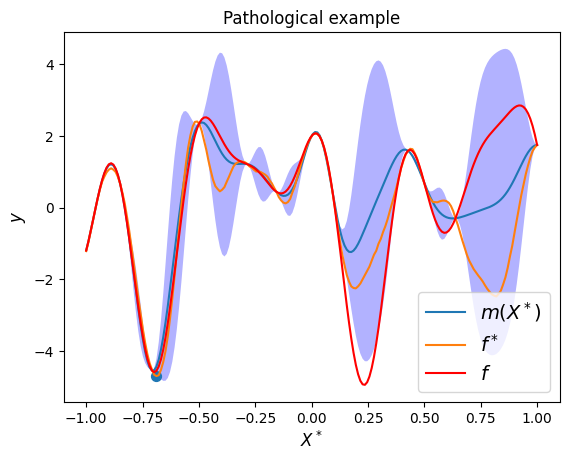

In [139]:
for i in range(1):
    print(i)
    pyro.clear_param_store()
    kernel = gp.kernels.RBF(input_dim=1)
    kernel.variance = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))

    kernel.lengthscale = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))

    gpmodel = gp.models.GPRegression(X, y, kernel=kernel, noise = torch.tensor(1e-4))

    noise = torch.tensor(1e-4)

    hmc_kernel = pyro.infer.NUTS(gpmodel.model)

    mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=500, warmup_steps = 100)
    mcmc.run()

    hyperparam = mcmc.get_samples()
    x1 = hyperparam["kernel.lengthscale"]
    y1 = hyperparam["kernel.variance"]

    while(True):
        try:
            idx = torch.randint(0, 100, (1,))

            gpmodel.kernel.variance = y1[idx]

            gpmodel.kernel.lengthscale = x1[idx]

            loc, cov = gpmodel.forward(x_test, full_cov= True)

            cov = cov + noise.expand(x_test.shape[0]).diag()
        
        
            samples = dist.MultivariateNormal(loc, covariance_matrix=cov, validate_args = False).sample(sample_shape=(1,))
            min_value, min_idx = torch.min(samples[0], dim = 0, keepdim=False)
            xstar = x_test[min_idx.item()].reshape(1)
            if not (xstar in X):
                break
        except:
            print("Try again")

    mean_new = gpmodel.forward(x_test)[0] # Returns the mean of our posterior samples
    sd_new = gpmodel.forward(x_test)[1] # Returns the standard deviation of our posteriour samples
    fstar = target_func(xstar)


    
    with torch.no_grad():
        f, ax = plt.subplots(1)
       

        sns.lineplot(x = x_test, y = mean_new, ax=ax, label = "$m(X^*)$")
        ax.fill_between(x_test, mean_new+2*sd_new, mean_new-2*sd_new, facecolor='blue', alpha=0.3)

        sns.lineplot(x = x_test, y = samples[0], label = "$f^*$", ax = ax)
        #sns.scatterplot(x = X, y = y, marker= 'o', s = 50)

        ax.scatter(xstar, min_value, marker='o', s = 50)
        sns.lineplot(x = x_test, y = target_func(x_test), label = "$f$", ax = ax, color = "red")
        ax.legend(loc = "lower right", fontsize = 14)
        ax.set_xlabel("$X^*$", fontsize = 12, fontweight="bold")
        ax.set_ylabel("$y$", fontsize = 12, fontweight="bold")
        ax.set_title("Pathological example")
        plt.show()


    X = torch.cat((X, xstar), 0)
    y = torch.cat((y, fstar), 0)

In [87]:
ymin, idxmin = torch.min(y, dim = 0, keepdim=False)
argmin = X[idxmin]
print(argmin)

tensor(-1.)


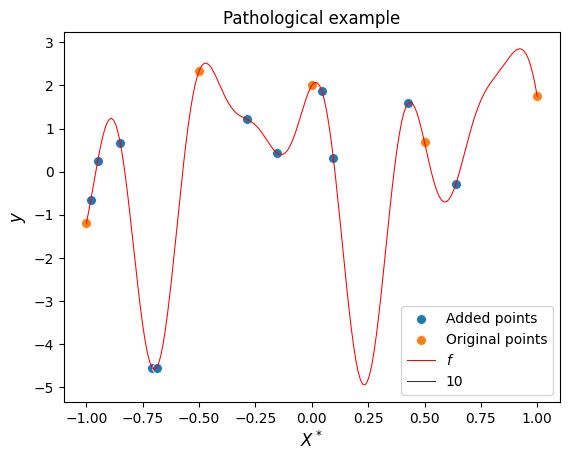

In [159]:
xOriginal = torch.tensor([-1, -1/2, 0, 1/2, 1])
yOriginal = target_func(xOriginal)

f, ax = plt.subplots(1)



sns.scatterplot(x = X, y = y , marker= 'o', s = 50, label = "Added points")
sns.scatterplot(x = xOriginal, y = yOriginal , marker= 'o', s = 50 , label = "Original points")


ax.legend(loc = "upper right", fontsize = 14)
sns.lineplot(x = x_test, y = target_func(x_test), color = "red", size = 10, label = "$f$")
ax.set_xlabel("$X^*$", fontsize = 12, fontweight="bold")
ax.set_ylabel("$y$", fontsize = 12, fontweight="bold")
ax.set_title("Pathological example")
plt.show()


In [69]:
argmin_array[3] = argmin

NameError: name 'argmin_array' is not defined